# Data Setup

In [0]:
from google.colab import drive

In [0]:
drive.mount('./gdrive')

In [3]:
!ls

gdrive	sample_data


In [0]:
import os

In [0]:
os.chdir('./gdrive/My Drive/Google Colaboratory/Colab Notebooks/Data Science   Machine Learning/Beatles NLP/Data')

In [0]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline

In [0]:
!pip install tqdm --upgrade

In [0]:
from tqdm import tqdm, tqdm_notebook

In [0]:
# using tqdm to get a progress bar on long-loading processes
tqdm.pandas(tqdm_notebook)

In [0]:
# reading in the big Beatles data Excel file into a Pandas dataframe. 
# The Beatles data will continue everything we need, including song names, album names, songwriters, lyrics, and more

data = pd.read_excel('beatles_data.xlsx')

# Raw Data Exploration

In [0]:
data.head()

,Song,Album Debut,Songwriter(s),Lead Vocal(s),Year,Lyrics
0,"""12-Bar Original""",Anthology 2,John Lennon\n Paul McCartney\n George Harrison...,Instrumental,1965,NaN
1,"""Across the Universe""",Let It Be,Lennon,Lennon,1968,Words are flowing out like endless rain into a...
2,"""All I've Got to Do""",UK: With the Beatles\n US: Meet the Beatles!,Lennon,Lennon,1963,Whenever I want you around yeh \nAll I gotta d...
3,"""All My Loving""",UK: With the Beatles\n US: Meet the Beatles!,McCartney,McCartney,1963,Close your eyes and I'll kiss you\nTomorrow I'...
4,"""All Things Must Pass""",Anthology 3,Harrison,Harrison,1969,"Sunrise doesn't last all morning, \nA cloudbur..."


In [0]:
list(data)

['Song', 'Album Debut', 'Songwriter(s)', 'Lead Vocal(s)', 'Year', 'Lyrics']

In [0]:
# We will remove any songs that have something for lyrics (aka non-instrumental songs)
data = data[data['Lyrics'].notnull()]

In [0]:
data['Songwriter(s)']

1                         Lennon
2                         Lennon
3                      McCartney
4                       Harrison
5      McCartney\n (with Lennon)
                 ...            
213                    McCartney
214           Lennon\n McCartney
215                    McCartney
216                       Lennon
217                       Lennon
Name: Songwriter(s), Length: 213, dtype: object

In [0]:
data[data['Songwriter(s)'] == 'Lennon']

,Song,Album Debut,Songwriter(s),Lead Vocal(s),Year,Lyrics
1,"""Across the Universe""",Let It Be,Lennon,Lennon,1968,Words are flowing out like endless rain into a...
2,"""All I've Got to Do""",UK: With the Beatles\n US: Meet the Beatles!,Lennon,Lennon,1963,Whenever I want you around yeh \nAll I gotta d...
6,"""All You Need Is Love""",Magical Mystery Tour,Lennon,Lennon,1967,"Love, love, love\nLove, love, love\nLove, love..."
15,"""Bad to Me""",The Beatles Bootleg Recordings 1963,Lennon,Lennon,1963,"If you ever leave me, I'll be sad and blue\nDo..."
16,"""The Ballad of John and Yoko""",UK: 1967–1970\n US: Hey Jude,Lennon,Lennon\n (with McCartney),1969,Standing in the dock at Southampton\nTrying to...
17,"""Because""",Abbey Road,Lennon,Lennon\n McCartney\n Harrison[26],1969,Because the world is round it turns me on\nBec...
26,"""Child of Nature""",Let It Be... Naked - Fly on the Wall bonus disc,Lennon,Lennon,1968,On the road to Rishikesh\nI was dreaming more ...
30,"""Come Together""",Abbey Road,Lennon,Lennon,1969,Here come old flat top\nHe come grooving up sl...
31,"""The Continuing Story of Bungalow Bill""",The Beatles,Lennon,Lennon,1968,"Hey, Bungalow Bill\nWhat did you kill\nBungalo..."
32,"""Cry Baby Cry”",The Beatles,Lennon,Lennon\n (with McCartney),1968,Cry baby cry\nMake your mother sigh\nShe's old...


# Pre-processing the Data

We will break down the data into individual lyric lines.

In [0]:
import spacy
import en_core_web_sm

In [0]:
def preprocessing_songs(df):

  df['Lyric Line'] = df['Lyrics'].apply(lambda x: x.split('\n'))
  df = df.set_index(['Song', 'Album Debut', 'Songwriter(s)', 'Lead Vocal(s)', 'Year'])['Lyric Line'].apply(pd.Series).stack().reset_index().drop('level_5',1)
  df.rename(columns={0:'Lyric Line'}, inplace=True)

  print('Removing quotes from song...')
  df['Song'] = df['Song'].apply(lambda x: remove_song_quotes(x))

  print('Cleaning songwriter(s) column...')
  df['Songwriter(s)'] = df['Songwriter(s)'].apply(lambda x: condense_band_members(x))
  
  print('Cleaning lead vocals(s) column...')
  df['Lead Vocal(s)'] = df['Lead Vocal(s)'].apply(lambda x: condense_band_members(x))

  print('Counting the number of distinct lines in the lyrics.')
  df['Number Lines'] = df['Lyric Line'].apply(lambda x: number_lines(x))

  print('Counting the number of words in each song.')
  df['Number Words'] = df['Lyric Line'].apply(lambda x: number_words(x))

  print('Calculating the average number of words in each line.')
  df['Average Words Per Line'] = df.apply(lambda row: words_per_line(row['Number Lines'], row['Number Words']), axis=1)

  print('Counting the number of apostrophes in each song.')
  df['Number Apostrophes'] = df['Lyric Line'].apply(lambda x: apostrophe_count(x))

  print('Calculating the average number of words in each line.')
  df['Average Words Per Apostrophe'] = df.apply(lambda row: words_per_apostrophe(row['Number Words'], row['Number Apostrophes']), axis=1)

  print('Cleaning lyrics...')
  df['Cleaned Lyrics'] = clean_text(df, 'Lyric Line')

  return df

  

In [0]:
def pre_processing_songs_nlp(df):
  print('Extracting NLP features...')
  df['NLP Features'] = df['Cleaned Lyrics'].progress_apply(lambda x: nlp_pipeline(x))

  df = df.dropna()

  df['Tokens'] = df['NLP Features'].apply(lambda x: x['tokens'])

  df['Lemmas'] = df['NLP Features'].apply(lambda x: x['lemmas'])

  df['Lemmas Text'] = df['Lemmas'].apply(lambda x: ' '.join(x))

  df['Album Debut'] = df['Album Debut'].str.replace(r"\n", " ")
  
  # Replace two spaces with one space
  df['Album Debut'] = df['Album Debut'].str.replace(r"  ", " ")

  df = df.reset_index(drop=True)

  return df

  

In [0]:
def nlp_features(df):
  # Create dataframe of syntactic dependency relation counts 'dep'
    df_dep = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'dep_counter'))
    df_dep = df_dep.fillna(value = 0)

    # Create dataframe of coarse-grained parts-of-speech counts 'pos'
    df_pos = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'pos_counter'))
    df_pos = df_pos.fillna(value = 0)

    # Create dataframe of stop word counts 'stop'
    df_stop = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'stop_counter'))
    df_stop = df_stop.fillna(value = 0)

    # Create dataframe of fine-grained parts-of-speech counts 'tag'
    df_tag = df['NLP Features'].progress_apply(lambda x: nlp_dict_to_df(x, 'tag_counter'))
    df_tag = df_tag.fillna(value = 0)

    # Combine all NLP dataframes
    df_spacy = pd.concat([df_stop, df_pos, df_tag, df_dep], axis=1)

    df_spacy = df_spacy.reset_index(drop=True)

    return df_spacy

In [0]:
def remove_song_quotes(song_row):
  # Removes any quotations around songs
  try:
    song_row = re.sub(r'"', '', song_row)
  except:
    pass

  return song_row

In [0]:
def condense_band_members(row):
  # Create new pandas df column for either the individual songwriter or group songwriters
  if row =='Harrison':
    return row
  elif row == 'Lennon':
    return row
  elif row == 'McCartney':
    return row
  elif row == 'Starr':
    return row
  elif row == 'Instrumental':
    return row
  else:
    return 'Multiple Beatles'

In [0]:
def number_lines(lyrics_row):
  # Counts the number of distinct lines in the lyrics
  try:
    number_lines = lyrics_row.count('\n') + 1
    return number_lines
  except:
    return 0

In [0]:
def number_words(lyrics_row):
  # Counts the number of words in each song
  try:
    list_of_words = lyrics_row.split()
    number_words = len(list_of_words)
    return number_words
  except:
    return 0

In [0]:
def words_per_line(number_lines_row, number_words_row):
    # Calculates the average words per line
    
    if number_words_row == 0:
        # Don't want to return np.nan, return 0
        return 0
    else:
        average_words_per_line = number_words_row / number_lines_row
        return average_words_per_line

In [0]:
def apostrophe_count(lyrics_row):
    # Counts the number of apostrophes
    
    try:
        number_apostrophes = lyrics_row.count("'")
        return number_apostrophes
    except:
        return 0

In [0]:
def words_per_apostrophe(number_words_row, number_apostrophes_row):
    # Calculates the average number of words used per apostrophe used
    
    if number_words_row == 0 or number_apostrophes_row == 0:
        # Don't want to return np.nan, return 0
        return 0
    else:
        average_words_per_apostrophe = number_words_row / number_apostrophes_row
        return average_words_per_apostrophe

In [0]:
def clean_text(df, df_column):
    """
    Removing line breaks, special characters.
    Setting all letters to lowercase -- EXCEPT for pronoun I, kept capitalized.
    """
    
    # Replacing line breaks with one space
    df['Cleaned Lyrics'] = df[df_column].str.replace(r"\n", " ")
    
    # Removing special characters
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r"[.,?!();:]", "")
    
    # Replace two spaces with one space
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r"  ", " ")
    
    # Lower-case all words
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.lower()
    
    # Upper-case the pronouns I -- this helps with Spacy Lemmatization
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r" i i ", " I I ")
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r" i ", " I ")
    df['Cleaned Lyrics'] = df['Cleaned Lyrics'].str.replace(r" i'", " I'")
    
    return df['Cleaned Lyrics']


In [0]:
def remove_song_quotes(song_row):
    """
    Removing any quotation marks around songs.
    """      
    
    # Check if the song names have quotes around them (mine did)
    try:
        song_row = re.sub(r'"', '', song_row)
    except:
        pass
    
    return song_row

In [0]:
def nlp_pipeline(text_document):
    """
    Takes in a string and runs it through Spacy's NLP pipeline consisting of a 
    Tokenizer, Tagger, Dependency Parser, Entity Recognizer, Text Categorizer.
    NLP features are then extracted from each Token's Spacy attributes.
    NLP features are then aggregated for the entire text_document and returned in a dictionary.
    
    Inputs:
        text_document (str): Text data. In this case it is Beatles lyrics.
    
    Output:
        dict: Aggregated NLP features.
    """
    
    # Create Spacy NLP pipeline
    nlp = en_core_web_sm.load() 
    
    # Check if text is not a string, if so return np.nan
    if type(text_document) != str:
        return np.nan
    
    # Run Spacy NLP pipeline on text_document, creates DOC object filled with tokens
    doc = nlp(text_document)

    # Tokenization
    tokens = [tok.orth_ for tok in doc]

    # Lemmatization
    lemmas = [tok.lemma_ for tok in doc]

    # Create counter dictionaries to collect counts of NLP features
    pos_counter = {}   # Coarse-grained part-of-speech
    tag_counter = {}   # Fine-grained part-of-speech.
    stop_counter = {}   # Stop word or not
    dep_counter = {}   # Syntactic dependency relation

    # Loop through each Token object contained in Doc object
    for token in doc:

        # Add token 'POS' to dictionary
        pos = "pos_" + token.pos_
        if pos in pos_counter.keys():
            pos_counter[pos] += 1
        else:
            pos_counter[pos] = 1

        # Add token 'TAG' to dictionary
        tag = "tag_" + token.tag_
        if tag in tag_counter.keys():
            tag_counter[tag] += 1
        else:
            tag_counter[tag] = 1

        # Add token 'STOP' to dictionary
        stop = "stop_" + str(token.is_stop)
        if stop in stop_counter.keys():
            stop_counter[stop] += 1
        else:
            stop_counter[stop] = 1

        # Add token 'DEP' to dictionary
        dep = "dep_" + token.dep_
        if dep in dep_counter.keys():
            dep_counter[dep] += 1
        else:
            dep_counter[dep] = 1

    # Combine NLP features into one dictionary
    nlp_dictionary = {'pos_counter' : pos_counter,
                      'tag_counter' : tag_counter,
                      'stop_counter' : stop_counter,
                      'dep_counter' : dep_counter,
                      'tokens' : tokens,
                      'lemmas' : lemmas}
    
    return nlp_dictionary

In [0]:
def nlp_dict_to_df(nlp_features, feature):
    """
    Take in nlp_features dictionary, outputs a pd.Series object 
    containing the NLP features.
    
    Inputs:
        nlp_features (dict): Aggregated NLP features.
    
    Outputs:
        nlp_series (pd.Series): NLP features for each song obtained using Spacy.
    """
    
    # Dep dictionary
    nlp_dict = nlp_features[feature]

    # Total number of entries in dep dictionary
    nlp_total = np.sum(list(nlp_dict.values()))

    # Calculate fraction of total for each NLP feature (Normalization)
    nlp_dict_fractions = {k: v / nlp_total for k, v in nlp_dict.items()}

    # Turn into a pandas Series to return
    nlp_series = pd.Series(nlp_dict_fractions)
    
    return nlp_series

In [0]:
# we have a new dataframe with cleaned lyrics
new_df = preprocessing_songs(data)

In [0]:
new_df.head()

,Song,Album Debut,Songwriter(s),Lead Vocal(s),Year,Lyric Line,Number Lines,Number Words,Average Words Per Line,Number Apostrophes,Average Words Per Apostrophe,Cleaned Lyrics
0,Across the Universe,Let It Be,Lennon,Lennon,1968,Words are flowing out like endless rain into a...,1,11,11.0,0,0.0,words are flowing out like endless rain into a...
1,Across the Universe,Let It Be,Lennon,Lennon,1968,"They slither while they pass, they slip away a...",1,11,11.0,0,0.0,they slither while they pass they slip away ac...
2,Across the Universe,Let It Be,Lennon,Lennon,1968,"Pools of sorrow, waves of joy are drifting thr...",1,12,12.0,0,0.0,pools of sorrow waves of joy are drifting thro...
3,Across the Universe,Let It Be,Lennon,Lennon,1968,Possessing and caressing me.,1,4,4.0,0,0.0,possessing and caressing me
4,Across the Universe,Let It Be,Lennon,Lennon,1968,Jai Guru Deva Om,1,4,4.0,0,0.0,jai guru deva om


In [0]:
# we will add all of the NLP features to the dataframe
new_df = pre_processing_songs_nlp(new_df)

In [0]:
spacy_df = nlp_features(new_df)

100%|██████████| 5664/5664 [00:02<00:00, 2300.75it/s]


In [0]:
new_df.head()

,Song,Album Debut,Songwriter(s),Lead Vocal(s),Year,Lyric Line,Number Lines,Number Words,Average Words Per Line,Number Apostrophes,Average Words Per Apostrophe,Cleaned Lyrics,NLP Features,Tokens,Lemmas,Lemmas Text
0,Across the Universe,Let It Be,Lennon,Lennon,1968,Words are flowing out like endless rain into a...,1,11,11.0,0,0.0,words are flowing out like endless rain into a...,"{'pos_counter': {'pos_NOUN': 4, 'pos_VERB': 2,...","[words, are, flowing, out, like, endless, rain...","[word, be, flow, out, like, endless, rain, int...",word be flow out like endless rain into a pape...
1,Across the Universe,Let It Be,Lennon,Lennon,1968,"They slither while they pass, they slip away a...",1,11,11.0,0,0.0,they slither while they pass they slip away ac...,"{'pos_counter': {'pos_PRON': 3, 'pos_VERB': 3,...","[they, slither, while, they, pass, they, slip,...","[-PRON-, slither, while, -PRON-, pass, -PRON-,...",-PRON- slither while -PRON- pass -PRON- slip a...
2,Across the Universe,Let It Be,Lennon,Lennon,1968,"Pools of sorrow, waves of joy are drifting thr...",1,12,12.0,0,0.0,pools of sorrow waves of joy are drifting thro...,"{'pos_counter': {'pos_NOUN': 5, 'pos_ADP': 3, ...","[pools, of, sorrow, waves, of, joy, are, drift...","[pool, of, sorrow, wave, of, joy, be, drift, t...",pool of sorrow wave of joy be drift through -P...
3,Across the Universe,Let It Be,Lennon,Lennon,1968,Possessing and caressing me.,1,4,4.0,0,0.0,possessing and caressing me,"{'pos_counter': {'pos_VERB': 2, 'pos_CCONJ': 1...","[possessing, and, caressing, me]","[possess, and, caress, -PRON-]",possess and caress -PRON-
4,Across the Universe,Let It Be,Lennon,Lennon,1968,Jai Guru Deva Om,1,4,4.0,0,0.0,jai guru deva om,"{'pos_counter': {'pos_NOUN': 4}, 'tag_counter'...","[jai, guru, deva, om]","[jai, guru, deva, om]",jai guru deva om


In [0]:
spacy_df.head()

,stop_False,stop_True,pos_NOUN,pos_VERB,pos_PART,pos_ADP,pos_ADJ,pos_DET,pos_PRON,pos_ADV,pos_CCONJ,pos_NUM,pos_AUX,pos_INTJ,pos_X,pos_PUNCT,pos_PROPN,pos_SYM,pos_SPACE,tag_NNS,tag_VBP,tag_VBG,tag_RP,tag_IN,tag_JJ,tag_NN,tag_DT,tag_PRP,tag_RB,tag_PRP$,tag_VBN,tag_CC,tag_VBZ,tag_TO,tag_VB,tag_WDT,tag_CD,tag_WRB,tag_VBD,tag_MD,...,dep_amod,dep_pobj,dep_det,dep_compound,dep_mark,dep_advcl,dep_ccomp,dep_advmod,dep_poss,dep_cc,dep_conj,dep_dobj,dep_nsubjpass,dep_auxpass,dep_xcomp,dep_relcl,dep_nummod,dep_oprd,dep_acl,dep_attr,dep_acomp,dep_intj,dep_npadvmod,dep_dative,dep_predet,dep_neg,dep_case,dep_pcomp,dep_quantmod,dep_meta,dep_subtok,dep_expl,dep_dep,dep_punct,dep_parataxis,dep_nmod,dep_appos,dep_agent,dep_csubj,dep_
0,0.636364,0.363636,0.363636,0.181818,0.090909,0.181818,0.090909,0.090909,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.090909,0.090909,0.090909,0.181818,0.090909,0.272727,0.090909,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.090909,0.181818,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.454545,0.545455,0.090909,0.272727,0.000000,0.181818,0.000000,0.090909,0.272727,0.090909,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.272727,0.000000,0.000000,0.181818,0.000000,0.090909,0.090909,0.272727,0.090909,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.090909,0.090909,0.000000,0.090909,0.090909,0.090909,0.090909,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.583333,0.416667,0.416667,0.250000,0.000000,0.250000,0.000000,0.083333,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.083333,0.083333,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.083333,0.083333,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.083333,0.250000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.500000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
new_df.to_csv('data.csv')

In [0]:
spacy_df.to_csv('spacy.csv')

# Modeling

In [0]:
data = new_df
spacy = spacy_df

In [0]:
# Checking for class imbalance
data['Songwriter(s)'].value_counts()

Multiple Beatles    1927
Lennon              1629
McCartney           1488
Harrison             612
Starr                  8
Name: Songwriter(s), dtype: int64

In [0]:
data[data['Songwriter(s)'] == 'Starr']

,Song,Album Debut,Songwriter(s),Lead Vocal(s),Year,Lyric Line,Number Lines,Number Words,Average Words Per Line,Number Apostrophes,Average Words Per Apostrophe,Cleaned Lyrics,NLP Features,Tokens,Lemmas,Lemmas Text
4495,Taking a Trip to Carolina,Let It Be... Naked - Fly on the Wall bonus disc,Starr,Starr,1969,Taking a trip on an ocean liner,1,7,7.0,0,0.0,taking a trip on an ocean liner,"{'pos_counter': {'pos_VERB': 1, 'pos_DET': 2, ...","[taking, a, trip, on, an, ocean, liner]","[take, a, trip, on, an, ocean, liner]",take a trip on an ocean liner
4496,Taking a Trip to Carolina,Let It Be... Naked - Fly on the Wall bonus disc,Starr,Starr,1969,I'm gonna get to Carolina,1,5,5.0,1,5.0,i'm gonna get to carolina,"{'pos_counter': {'pos_PRON': 1, 'pos_VERB': 3,...","[i, 'm, gon, na, get, to, carolina]","[-PRON-, be, go, to, get, to, carolina]",-PRON- be go to get to carolina
4497,Taking a Trip to Carolina,Let It Be... Naked - Fly on the Wall bonus disc,Starr,Starr,1969,Taking a trip on an ocean liner,1,7,7.0,0,0.0,taking a trip on an ocean liner,"{'pos_counter': {'pos_VERB': 1, 'pos_DET': 2, ...","[taking, a, trip, on, an, ocean, liner]","[take, a, trip, on, an, ocean, liner]",take a trip on an ocean liner
4498,Taking a Trip to Carolina,Let It Be... Naked - Fly on the Wall bonus disc,Starr,Starr,1969,I'm gonna get to Carolina,1,5,5.0,1,5.0,i'm gonna get to carolina,"{'pos_counter': {'pos_PRON': 1, 'pos_VERB': 3,...","[i, 'm, gon, na, get, to, carolina]","[-PRON-, be, go, to, get, to, carolina]",-PRON- be go to get to carolina
4499,Taking a Trip to Carolina,Let It Be... Naked - Fly on the Wall bonus disc,Starr,Starr,1969,Taking a trip on an ocean liner,1,7,7.0,0,0.0,taking a trip on an ocean liner,"{'pos_counter': {'pos_VERB': 1, 'pos_DET': 2, ...","[taking, a, trip, on, an, ocean, liner]","[take, a, trip, on, an, ocean, liner]",take a trip on an ocean liner
4500,Taking a Trip to Carolina,Let It Be... Naked - Fly on the Wall bonus disc,Starr,Starr,1969,I'm gonna get to Carolina,1,5,5.0,1,5.0,i'm gonna get to carolina,"{'pos_counter': {'pos_PRON': 1, 'pos_VERB': 3,...","[i, 'm, gon, na, get, to, carolina]","[-PRON-, be, go, to, get, to, carolina]",-PRON- be go to get to carolina
4501,Taking a Trip to Carolina,Let It Be... Naked - Fly on the Wall bonus disc,Starr,Starr,1969,Taking a trip on an ocean liner,1,7,7.0,0,0.0,taking a trip on an ocean liner,"{'pos_counter': {'pos_VERB': 1, 'pos_DET': 2, ...","[taking, a, trip, on, an, ocean, liner]","[take, a, trip, on, an, ocean, liner]",take a trip on an ocean liner
4502,Taking a Trip to Carolina,Let It Be... Naked - Fly on the Wall bonus disc,Starr,Starr,1969,I'm gonna get to Carolina,1,5,5.0,1,5.0,i'm gonna get to carolina,"{'pos_counter': {'pos_PRON': 1, 'pos_VERB': 3,...","[i, 'm, gon, na, get, to, carolina]","[-PRON-, be, go, to, get, to, carolina]",-PRON- be go to get to carolina


We're going to drop Ringo from the list. Sorry Ringo, poor lad.

In [0]:
data = data.drop([4495, 4496, 4497, 4498, 4499, 4500])


In [0]:
spacy = spacy.drop([4495, 4496, 4497, 4498, 4499, 4500])

In [0]:
data = data.drop([4501, 4502])
spacy = spacy.drop([4501, 4502])

In [0]:
data = data.reset_index(drop=True)
spacy = spacy.reset_index(drop=True)

In [0]:
data = data.drop("Unnamed: 0", axis=1)

In [0]:
data.head()

,Song,Album Debut,Songwriter(s),Lead Vocal(s),Year,Lyric Line,Number Lines,Number Words,Average Words Per Line,Number Apostrophes,Average Words Per Apostrophe,Cleaned Lyrics,NLP Features,Tokens,Lemmas,Lemmas Text
0,Across the Universe,Let It Be,Lennon,Lennon,1968,Words are flowing out like endless rain into a...,1,11,11.0,0,0.0,words are flowing out like endless rain into a...,"{'pos_counter': {'pos_NOUN': 4, 'pos_VERB': 2,...","[words, are, flowing, out, like, endless, rain...","[word, be, flow, out, like, endless, rain, int...",word be flow out like endless rain into a pape...
1,Across the Universe,Let It Be,Lennon,Lennon,1968,"They slither while they pass, they slip away a...",1,11,11.0,0,0.0,they slither while they pass they slip away ac...,"{'pos_counter': {'pos_PRON': 3, 'pos_VERB': 3,...","[they, slither, while, they, pass, they, slip,...","[-PRON-, slither, while, -PRON-, pass, -PRON-,...",-PRON- slither while -PRON- pass -PRON- slip a...
2,Across the Universe,Let It Be,Lennon,Lennon,1968,"Pools of sorrow, waves of joy are drifting thr...",1,12,12.0,0,0.0,pools of sorrow waves of joy are drifting thro...,"{'pos_counter': {'pos_NOUN': 5, 'pos_ADP': 3, ...","[pools, of, sorrow, waves, of, joy, are, drift...","[pool, of, sorrow, wave, of, joy, be, drift, t...",pool of sorrow wave of joy be drift through -P...
3,Across the Universe,Let It Be,Lennon,Lennon,1968,Possessing and caressing me.,1,4,4.0,0,0.0,possessing and caressing me,"{'pos_counter': {'pos_VERB': 2, 'pos_CCONJ': 1...","[possessing, and, caressing, me]","[possess, and, caress, -PRON-]",possess and caress -PRON-
4,Across the Universe,Let It Be,Lennon,Lennon,1968,Jai Guru Deva Om,1,4,4.0,0,0.0,jai guru deva om,"{'pos_counter': {'pos_NOUN': 4}, 'tag_counter'...","[jai, guru, deva, om]","[jai, guru, deva, om]",jai guru deva om


In [0]:
spacy = spacy.drop("Unnamed: 0", axis=1)

In [0]:
spacy.head()

,stop_False,stop_True,pos_NOUN,pos_VERB,pos_PART,pos_ADP,pos_ADJ,pos_DET,pos_PRON,pos_ADV,pos_CCONJ,pos_NUM,pos_AUX,pos_INTJ,pos_X,pos_PUNCT,pos_PROPN,pos_SYM,pos_SPACE,tag_NNS,tag_VBP,tag_VBG,tag_RP,tag_IN,tag_JJ,tag_NN,tag_DT,tag_PRP,tag_RB,tag_PRP$,tag_VBN,tag_CC,tag_VBZ,tag_TO,tag_VB,tag_WDT,tag_CD,tag_WRB,tag_VBD,tag_MD,...,dep_amod,dep_pobj,dep_det,dep_compound,dep_mark,dep_advcl,dep_ccomp,dep_advmod,dep_poss,dep_cc,dep_conj,dep_dobj,dep_nsubjpass,dep_auxpass,dep_xcomp,dep_relcl,dep_nummod,dep_oprd,dep_acl,dep_attr,dep_acomp,dep_intj,dep_npadvmod,dep_dative,dep_predet,dep_neg,dep_case,dep_pcomp,dep_quantmod,dep_meta,dep_subtok,dep_expl,dep_dep,dep_punct,dep_parataxis,dep_nmod,dep_appos,dep_agent,dep_csubj,dep_
0,0.636364,0.363636,0.363636,0.181818,0.090909,0.181818,0.090909,0.090909,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.090909,0.090909,0.090909,0.181818,0.090909,0.272727,0.090909,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.090909,0.181818,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.454545,0.545455,0.090909,0.272727,0.000000,0.181818,0.000000,0.090909,0.272727,0.090909,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.272727,0.000000,0.000000,0.181818,0.000000,0.090909,0.090909,0.272727,0.090909,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.090909,0.090909,0.000000,0.090909,0.090909,0.090909,0.090909,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.583333,0.416667,0.416667,0.250000,0.000000,0.250000,0.000000,0.083333,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.083333,0.083333,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.083333,0.083333,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.083333,0.250000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.500000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
data['Songwriter(s)'].value_counts()

Multiple Beatles    1927
Lennon              1629
McCartney           1488
Harrison             612
Name: Songwriter(s), dtype: int64

In [0]:
print(data.shape)
print(spacy.shape)


(5656, 16)
(5656, 104)


### Bag of Words

In [0]:
import itertools

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [0]:
data['Lemmas Text']

0       word be flow out like endless rain into a pape...
1       -PRON- slither while -PRON- pass -PRON- slip a...
2       pool of sorrow wave of joy be drift through -P...
3                               possess and caress -PRON-
4                                        jai guru deva om
                              ...                        
5651                             " love will find a way "
5652                        gather round all -PRON- clown
5653                           let -PRON- hear -PRON- say
5654         hey -PRON- have get to hide -PRON- love away
5655         hey -PRON- have get to hide -PRON- love away
Name: Lemmas Text, Length: 5656, dtype: object

In [0]:
# Define X and y
y = data['Songwriter(s)']
X = data['Lemmas Text']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 444)

# Vocabulary of lemmas, use with CountVectorizer
vocabulary = set(itertools.chain.from_iterable(data['Lemmas']))

# Count vectorizer and the index-to-word mapping
count_vectorizer = CountVectorizer(vocabulary=vocabulary)

# Create bag-of-word embeddings using vectorizer
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Convert to a pandas dataframe
X_train_counts = pd.DataFrame(X_train_counts.todense())
X_test_counts = pd.DataFrame(X_test_counts.todense())

# Create a mapping from index-to-word for the bag of words
index_to_word = {v:k for k,v in count_vectorizer.vocabulary_.items()}

In [0]:
X_train_counts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4519,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4522,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Latent Semantic Analysis of BoW Embedding

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder


In [0]:
le = LabelEncoder()
le.fit(y_train)
y_train_encoded = le.transform(y_train)

In [0]:
def plot_LSA(test_data, test_labels, plot=True):
    """
    This function first uses SK-Learn's truncated SVD (LSA) class to 
    transform the high dimensionality (number of columns) of the BoW 
    embedding down to 2 dimensions. Then the two dimensions are used
    to plot each song, colored by the song writer (class).
    
    Inputs:
        test_data (pd.DataFrame): BoW embeddings.
        test_labels (pd.Series): In this case the songwriter of each
        Beatles' song.
        plot (boolean): Whether or not to plot. Defaults to True.
    
    Outputs:
        None.
    """
    
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['blue','green','purple', 'red']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        blue_patch = mpatches.Patch(color='blue', label='Harrison')
        green_patch = mpatches.Patch(color='green', label='Lennon')
        purple_patch = mpatches.Patch(color='purple', label='McCartney')
        orange_patch = mpatches.Patch(color='red', label='Multiple Beatles')
        plt.legend(handles=[blue_patch, green_patch, purple_patch, orange_patch], prop={'size': 18})
        plt.xlabel('Principal Component One')
        plt.ylabel('Principal Component Two')
        plt.rcParams["xtick.labelsize"] = 20
        plt.rcParams["ytick.labelsize"] = 20




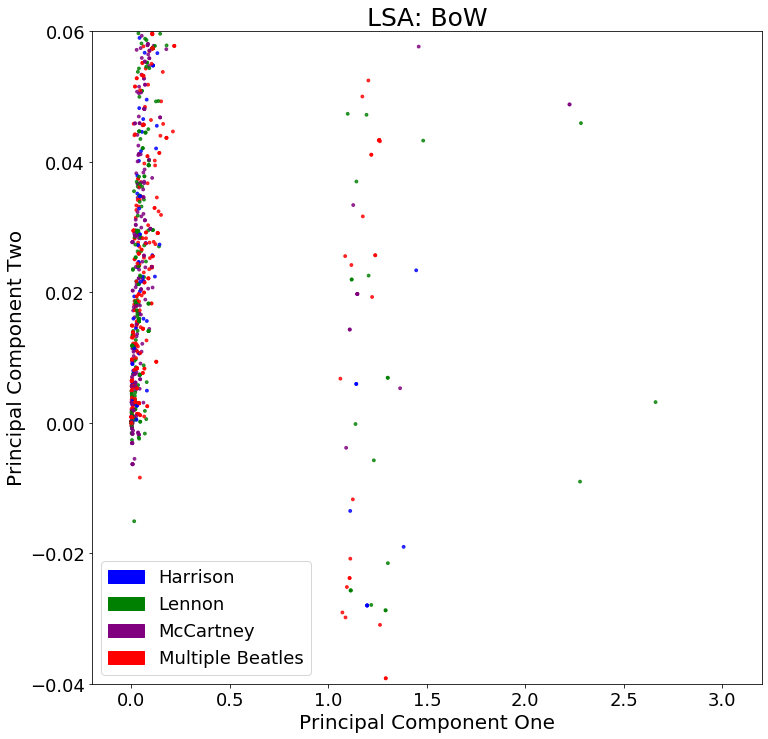

In [0]:
# Run LSA on BoW embeddings and plot it
fig = plt.figure(figsize=(12, 12))
plot_LSA(X_train_counts, y_train_encoded)
plt.title('LSA: BoW', fontsize = 25)
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["axes.labelsize"] = 20
plt.xlim(-0.2, 3.2)
plt.ylim(-0.04, 0.06)
plt.show()

### Latent Semantic Analysis of BoW Embedding + TFIDF

In [0]:
y = data['Songwriter(s)']
X = data['Lemmas Text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 444)

vocabulary = set(itertools.chain.from_iterable(data['Lemmas']))

tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_tfidf = pd.DataFrame(X_train_tfidf.todense())
X_test_tfidf = pd.DataFrame(X_test_tfidf.todense())

index_to_word = {v:k for k, v in count_vectorizer.vocabulary_.items()}

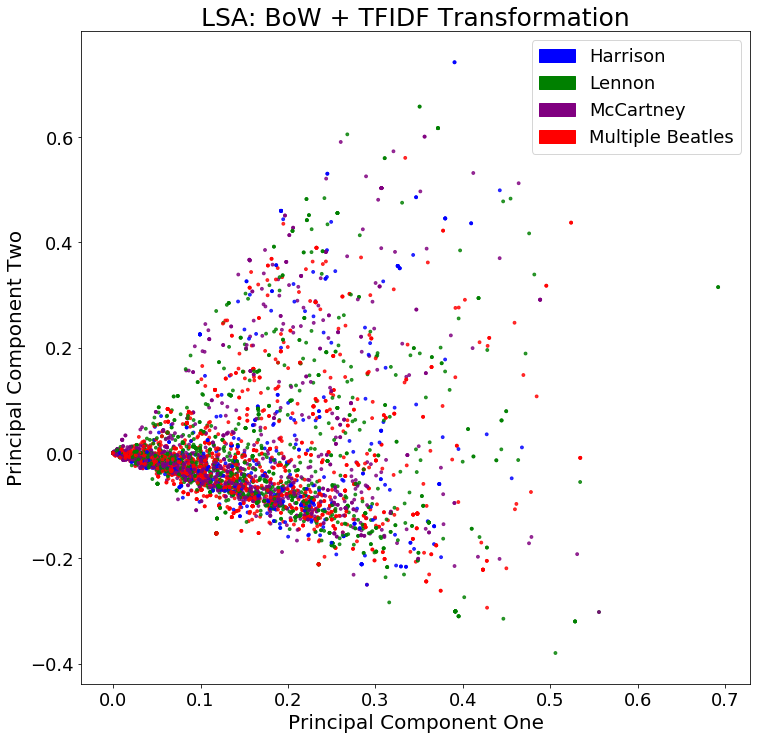

In [0]:
fig = plt.figure(figsize=(12,12))
plot_LSA(X_train_tfidf, y_train_encoded)
plt.title('LSA: BoW + TFIDF Transformation', fontsize= 25)
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["axes.labelsize"] = 20
plt.show()

### Latent Semantic Analysis: Spacy NLP Features

In [0]:
y = data['Songwriter(s)']
X = spacy

le = LabelEncoder()
le.fit(y)
y_encoded = le.transform(y)



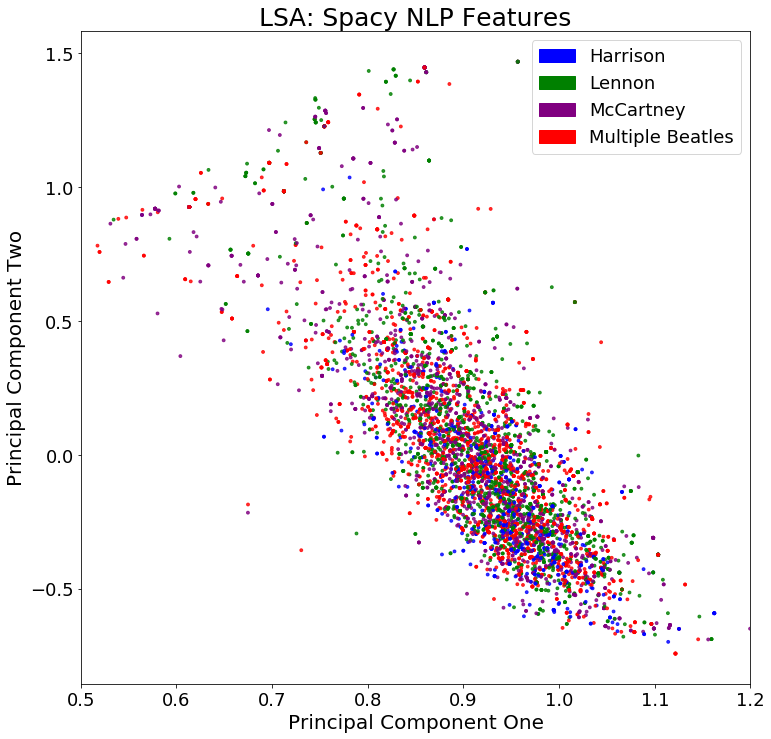

In [0]:
fig = plt.figure(figsize=(12, 12))
plot_LSA(X, y_encoded)
plt.title('LSA: Spacy NLP Features', fontsize = 25)
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["axes.labelsize"] = 20
plt.xlim(0.5, 1.2)
plt.show()

## Modeling

We will use two machine learning algorithms to create models that will predict the songwriters of the various songs using only the lyrics as the independent variable. Then we'll use the get_most_important_features() function to pinpoint the most important words for each songwriter.

In [0]:
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [0]:
y = data['Songwriter(s)']
X = data['Cleaned Lyrics']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 444)

vocabulary = set(itertools.chain.from_iterable(data['Cleaned Lyrics']))

count_vectorizer = CountVectorizer(vocabulary=vocabulary)

### Logistic Regression Grid Search Pipeline

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
!pip3 install pactools

In [0]:
from pactools.grid_search import GridSearchCVProgressBar

### We want to optimize to find the best estimator parameters

In [0]:


# Pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),])


# pipeline uses intermediate steps of CountVectorizer() and TfidfTransformer() before finally applying log regression

# This pipeline will be used as the estimator in the GridSearchCV


# Parameter Grid
param_grid = {
        'vect__max_df': (0.05, 0.075, 0.1, 0.15, 0.20, 0.25, 0.5, 0.75, 1.0),
        'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
        'vect__stop_words' : (None, 'english'),
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


# Create the GridSearchCV object
#grid = GridSearchCV(pipeline, cv=10, n_jobs=-1, param_grid=param_grid, scoring=make_scorer(accuracy_score))
grid = GridSearchCVProgressBar(pipeline, cv=2, n_jobs=-1, param_grid=param_grid, scoring=make_scorer(accuracy_score))


# Run the grid search 
grid.fit(X_train, y_train)

# Predicts usings the best parameters of the grid search
y_pred = grid.predict(X_test)

# Accuracy Score
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))
print()

# Classification Report
print(classification_report(y_test, y_pred, digits=3))
print()

# Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print()

# Best parameters from the grid search
print('Best parameters set found on development set:')
print(grid.best_params_)
print()

In [0]:
 def get_most_important_features(vectorizer, model, n=5):
    """
    This function is used to find the most important ngrams (words) 
    for classifying each class (songwriter).
    
    Args:
        vectorizer (sklearn.feature_extraction.text.CountVectorizer):
        The vectorizer used to create the Bag of Words space matrix.
        model (sklearn.linear_model.logistic.LogisticRegression):
        The LR model trained on the dataset.
        n (int): Number of top words to return.
    
    Returns:
        important_words (dict): Dicitionary containing the most
        critical words used to predict each songwriter class.
    """
    
    # Create a mapping dictionary from words to index
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    important_words = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        important_words[class_index] = {'tops':tops, 'bottom':bottom}
    
    return important_words




Running Logistic Regression and finding the most important words

In [0]:
# Vectorize
vectorizer = CountVectorizer(max_df = 0.1, ngram_range = (1, 2))
X_train_counts = vectorizer.fit_transform(X_train).todense()
X_test_counts = vectorizer.transform(X_test).todense()

# Tfidf transformation
tfidf = TfidfTransformer(norm = 'l2', use_idf = False)
X_train_counts_tfidf = tfidf.fit_transform(X_train_counts).todense()
X_test_counts_tfidf = tfidf.fit_transform(X_test_counts).todense()

clf = LogisticRegression(C = 10)
clf.fit(X_train_counts_tfidf, y_train)

# Create predictions, using trained model
y_pred = clf.predict(X_test_counts_tfidf)

# Find the most important words used for classification
importance = get_most_important_features(vectorizer, clf, 10)

# Re-name the dictionary keys
importance['Harrison'] = importance.pop(0)
importance['Lennon'] = importance.pop(1)
importance['McCartney'] = importance.pop(2)
importance['Multiple Beatles'] = importance.pop(3)

# Print the most important words
importance

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'Harrison': {'bottom': [(-2.045166065273923, 'cry'),
   (-2.0516036163996256, 'his'),
   (-2.074373830608004, 'down'),
   (-2.12649886774832, 'to make'),
   (-2.245646233845527, 'to be'),
   (-2.334401001365231, 'man'),
   (-2.603412111344155, 'yeah'),
   (-2.7788114268239608, 'better'),
   (-2.8376165191451923, 'but it'),
   (-3.245071662756538, 'he')],
  'tops': [(3.20668293232807, 'where you'),
   (3.2813107471829204, 'baby in'),
   (3.4526598680364975, 'it all'),
   (3.5652237899352883, 'really'),
   (3.654003225292855, 'too much'),
   (3.9902224848198466, 'got time'),
   (4.20846845653345, 'without'),
   (4.357034252936614, 'need you'),
   (4.579932179604316, 'to do'),
   (5.1964079560854515, 'me mine')]},
 'Lennon': {'bottom': [(-2.272389847767595, 'where'),
   (-2.2956971912605235, 'oh no'),
   (-2.3282633105894437, 'love you'),
   (-2.4086693661514875, 'here it'),
   (-2.4600020848978077, 'didn'),
   (-2.5905460013495665, 'know that'),
   (-2.614796732779806, 'my love'),
   (-

### Multinomial Naive Bayes Grid Search Pipeline

In [0]:
from sklearn.naive_bayes import MultinomialNB

In [0]:


# Pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())])

# Parameter Grid
param_grid = {
        'vect__max_df': (0.05, 0.075, 0.1, 0.15, 0.20, 0.25, 0.5, 0.75, 1.0),
        'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
        'vect__stop_words' : (None, 'english'),
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__alpha': (0, 0.001, 0.01, 0.1, 0.2, 0.25, 0.5, 0.75, 1.0)}

# Create the GridSearchCV object
grid = GridSearchCV(pipeline, cv=10, n_jobs=-1, param_grid=param_grid, scoring=make_scorer(accuracy_score))

# Run the grid search 
grid.fit(X_train, y_train)

# Predict usings the best parameters of the grid search
y_pred = grid.predict(X_test)

# Accuracy Score
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))
print()

# Classification Report
print(classification_report(y_test, y_pred, digits=3))
print()

# Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print()

# Best parameters from the grid search
print('Best parameters set found on development set:')
print(grid.best_params_)
print()

In [0]:
# Vectorize
vectorizer = CountVectorizer(max_df = 0.1, ngram_range = (1, 2))
X_train_counts = vectorizer.fit_transform(X_train).todense()
X_test_counts = vectorizer.transform(X_test).todense()

# Tfidf transformation
tfidf = TfidfTransformer(norm = 'l2', use_idf = False)
X_train_counts_tfidf = tfidf.fit_transform(X_train_counts).todense()
X_test_counts_tfidf = tfidf.fit_transform(X_test_counts).todense()

nb = MultinomialNB()
nb.fit(X_train_counts_tfidf, y_train)

# Create predictions, using trained model
y_pred = nb.predict(X_test_counts_tfidf)

# Find the most important words used for classification
importance = get_most_important_features(vectorizer, nb, 10)

# Re-name the dictionary keys
importance['Harrison'] = importance.pop(0)
importance['Lennon'] = importance.pop(1)
importance['McCartney'] = importance.pop(2)
importance['Multiple Beatles'] = importance.pop(3)

# Print the most important words
importance

{'Harrison': {'bottom': [(-9.377282492934983, 'your trust'),
   (-9.377282492934983, 'your voice'),
   (-9.377282492934983, 'yours sincerely'),
   (-9.377282492934983, 'yours yet'),
   (-9.377282492934983, 'yourself home'),
   (-9.377282492934983, 'yourself in'),
   (-9.377282492934983, 'yourself to'),
   (-9.377282492934983, 'zapped'),
   (-9.377282492934983, 'zapped in'),
   (-9.377282492934983, 'zoo what')],
  'tops': [(-7.106033702676536, 'not'),
   (-7.099118495814187, 'll'),
   (-7.0610869856031915, 'that'),
   (-6.910337502354965, 'if'),
   (-6.870088757600826, 'be'),
   (-6.857382826987659, 'know'),
   (-6.831224065606969, 'love'),
   (-6.545435529591376, 'don'),
   (-6.285568876248815, 'all'),
   (-6.179713804302713, 'it')]},
 'Lennon': {'bottom': [(-9.557661329838217, 'your voice'),
   (-9.557661329838217, 'your window'),
   (-9.557661329838217, 'yours sincerely'),
   (-9.557661329838217, 'yourself'),
   (-9.557661329838217, 'yourself home'),
   (-9.557661329838217, 'yourself

# Lyric Generation

In [0]:
from google.colab import files

In [0]:
import os, pandas as pd

In [0]:
os.chdir('./gdrive/My Drive/Google Colaboratory/Colab Notebooks/Data Science   Machine Learning/Beatles NLP/Data')

In [0]:
data = pd.read_csv('data.csv')

In [0]:
data.head()

,Unnamed: 0,Song,Album Debut,Songwriter(s),Lead Vocal(s),Year,Lyric Line,Number Lines,Number Words,Average Words Per Line,Number Apostrophes,Average Words Per Apostrophe,Cleaned Lyrics,NLP Features,Tokens,Lemmas,Lemmas Text
0,0,Across the Universe,Let It Be,Lennon,Lennon,1968,Words are flowing out like endless rain into a...,1,11,11.0,0,0.0,words are flowing out like endless rain into a...,"{'pos_counter': {'pos_NOUN': 4, 'pos_VERB': 2,...","['words', 'are', 'flowing', 'out', 'like', 'en...","['word', 'be', 'flow', 'out', 'like', 'endless...",word be flow out like endless rain into a pape...
1,1,Across the Universe,Let It Be,Lennon,Lennon,1968,"They slither while they pass, they slip away a...",1,11,11.0,0,0.0,they slither while they pass they slip away ac...,"{'pos_counter': {'pos_PRON': 3, 'pos_VERB': 3,...","['they', 'slither', 'while', 'they', 'pass', '...","['-PRON-', 'slither', 'while', '-PRON-', 'pass...",-PRON- slither while -PRON- pass -PRON- slip a...
2,2,Across the Universe,Let It Be,Lennon,Lennon,1968,"Pools of sorrow, waves of joy are drifting thr...",1,12,12.0,0,0.0,pools of sorrow waves of joy are drifting thro...,"{'pos_counter': {'pos_NOUN': 5, 'pos_ADP': 3, ...","['pools', 'of', 'sorrow', 'waves', 'of', 'joy'...","['pool', 'of', 'sorrow', 'wave', 'of', 'joy', ...",pool of sorrow wave of joy be drift through -P...
3,3,Across the Universe,Let It Be,Lennon,Lennon,1968,Possessing and caressing me.,1,4,4.0,0,0.0,possessing and caressing me,"{'pos_counter': {'pos_VERB': 2, 'pos_CCONJ': 1...","['possessing', 'and', 'caressing', 'me']","['possess', 'and', 'caress', '-PRON-']",possess and caress -PRON-
4,4,Across the Universe,Let It Be,Lennon,Lennon,1968,Jai Guru Deva Om,1,4,4.0,0,0.0,jai guru deva om,"{'pos_counter': {'pos_NOUN': 4}, 'tag_counter'...","['jai', 'guru', 'deva', 'om']","['jai', 'guru', 'deva', 'om']",jai guru deva om


In [0]:
data.rename(columns={'Unnamed: 0':'Line ID'}, inplace=True)

In [0]:
list(data)

['Line ID',
 'Song',
 'Album Debut',
 'Songwriter(s)',
 'Lead Vocal(s)',
 'Year',
 'Lyric Line',
 'Number Lines',
 'Number Words',
 'Average Words Per Line',
 'Number Apostrophes',
 'Average Words Per Apostrophe',
 'Cleaned Lyrics',
 'NLP Features',
 'Tokens',
 'Lemmas',
 'Lemmas Text']

In [0]:
data.head()

,Line ID,Song,Album Debut,Songwriter(s),Lead Vocal(s),Year,Lyric Line,Number Lines,Number Words,Average Words Per Line,Number Apostrophes,Average Words Per Apostrophe,Cleaned Lyrics,NLP Features,Tokens,Lemmas,Lemmas Text
0,0,Across the Universe,Let It Be,Lennon,Lennon,1968,Words are flowing out like endless rain into a...,1,11,11.0,0,0.0,words are flowing out like endless rain into a...,"{'pos_counter': {'pos_NOUN': 4, 'pos_VERB': 2,...","['words', 'are', 'flowing', 'out', 'like', 'en...","['word', 'be', 'flow', 'out', 'like', 'endless...",word be flow out like endless rain into a pape...
1,1,Across the Universe,Let It Be,Lennon,Lennon,1968,"They slither while they pass, they slip away a...",1,11,11.0,0,0.0,they slither while they pass they slip away ac...,"{'pos_counter': {'pos_PRON': 3, 'pos_VERB': 3,...","['they', 'slither', 'while', 'they', 'pass', '...","['-PRON-', 'slither', 'while', '-PRON-', 'pass...",-PRON- slither while -PRON- pass -PRON- slip a...
2,2,Across the Universe,Let It Be,Lennon,Lennon,1968,"Pools of sorrow, waves of joy are drifting thr...",1,12,12.0,0,0.0,pools of sorrow waves of joy are drifting thro...,"{'pos_counter': {'pos_NOUN': 5, 'pos_ADP': 3, ...","['pools', 'of', 'sorrow', 'waves', 'of', 'joy'...","['pool', 'of', 'sorrow', 'wave', 'of', 'joy', ...",pool of sorrow wave of joy be drift through -P...
3,3,Across the Universe,Let It Be,Lennon,Lennon,1968,Possessing and caressing me.,1,4,4.0,0,0.0,possessing and caressing me,"{'pos_counter': {'pos_VERB': 2, 'pos_CCONJ': 1...","['possessing', 'and', 'caressing', 'me']","['possess', 'and', 'caress', '-PRON-']",possess and caress -PRON-
4,4,Across the Universe,Let It Be,Lennon,Lennon,1968,Jai Guru Deva Om,1,4,4.0,0,0.0,jai guru deva om,"{'pos_counter': {'pos_NOUN': 4}, 'tag_counter'...","['jai', 'guru', 'deva', 'om']","['jai', 'guru', 'deva', 'om']",jai guru deva om


In [0]:
lyrics_data = data[['Line ID', 'Song', 'Album Debut', 'Songwriter(s)', 'Year', 'Cleaned Lyrics']]

In [0]:
lyrics_data.head()

,Line ID,Song,Album Debut,Songwriter(s),Year,Cleaned Lyrics
0,0,Across the Universe,Let It Be,Lennon,1968,words are flowing out like endless rain into a...
1,1,Across the Universe,Let It Be,Lennon,1968,they slither while they pass they slip away ac...
2,2,Across the Universe,Let It Be,Lennon,1968,pools of sorrow waves of joy are drifting thro...
3,3,Across the Universe,Let It Be,Lennon,1968,possessing and caressing me
4,4,Across the Universe,Let It Be,Lennon,1968,jai guru deva om


In [0]:
lyrics_data = lyrics_data.set_index('Line ID')

In [0]:
lyrics_data.head()

,Song,Album Debut,Songwriter(s),Year,Cleaned Lyrics
Line ID,,,,,
0,Across the Universe,Let It Be,Lennon,1968,words are flowing out like endless rain into a...
1,Across the Universe,Let It Be,Lennon,1968,they slither while they pass they slip away ac...
2,Across the Universe,Let It Be,Lennon,1968,pools of sorrow waves of joy are drifting thro...
3,Across the Universe,Let It Be,Lennon,1968,possessing and caressing me
4,Across the Universe,Let It Be,Lennon,1968,jai guru deva om


In [0]:
# We will read in all of the cleaned lyrics into a single text file for training
with open('lyricsText.txt', 'w', encoding='utf-8') as filehandle:
  for listitem in lyrics_data['Cleaned Lyrics']:
    filehandle.write('%s\n' % listitem)

## Using textgenrnn to generate lyrics

In [0]:
!pip install -q textgenrnn

In [0]:
from textgenrnn import textgenrnn

In [0]:
model_cfg = {
    'rnn_size': 128,
    'rnn_layers': 4,
    'rnn_bidirectional': True,
    'max_length': 40,
    'max_words': 10000,
    'dim_embeddings': 100,
    'word_level': False,
}

train_cfg = {
    'line_delimited': True,
    'num_epochs': 10, 
    'gen_epochs': 2,
    'batch_size': 1024,
    'train_size': 0.8,
    'dropout': 0.0,
    'max_gen_length': 300,
    'validation': True,
    'is_csv': False
}

In [0]:
text_file = 'lyricsText.txt'

In [0]:
model_name = '500nds_12Lrs_100epchs_Model'

In [0]:
model_name = '500nds_12Lrs_100epchs_Model'
textgen = textgenrnn(name=model_name)

train_function = textgen.train_from_file if train_cfg['line_delimited'] else textgen.train_from_largetext_file

train_function(
    file_path=text_file,
    new_model=True,
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=train_cfg['batch_size'],
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    max_gen_length=train_cfg['max_gen_length'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=model_cfg['dim_embeddings'],
    word_level=model_cfg['word_level'])












5,663 texts collected.
Training new model w/ 4-layer, 128-cell Bidirectional LSTMs
Training on 134,882 character sequences.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
131/131 [==============================] - 1124s 9s/step - loss: 2.7811 - val_loss: 2.1586
Epoch 2/10
131/131 [==============================] - 1108s 8s/step - loss: 2.0265 - val_loss: 1.9074
####################
Temperature: 0.2
####################
i could the coud you cand the goon

i love the with the love you cand the could to cour

i whe whe with a could the she with tour the soud I cone the love and the love the soud

####################
Temperature: 0.5
####################
i coud you me with a loood the cous I will the the the shen you coul to tour

wan I cand to me love the lowe I'll the criee

when don't the with you cone

####################
Temperature: 1.0
####################
dacl I'ly homendo gove thete aneaybine can by choum it 

In [0]:
print(textgen.model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 40)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      4100        input[0][0]                      
__________________________________________________________________________________________________
rnn_1 (Bidirectional)           (None, 40, 256)      234496      embedding[0][0]                  
__________________________________________________________________________________________________
rnn_2 (Bidirectional)           (None, 40, 256)      394240      rnn_1[0][0]                      
____________________________________________________________________________________________

In [0]:
weights_path = '{}_weights.hdf5'.format(model_name)


In [0]:
vocab_path = '500nds_12Lrs_100epchs_Model_vocab (1).json'

In [0]:
config_path = '500nds_12Lrs_100epchs_Model_config.json'

In [0]:
textgen = textgenrnn(weights_path=weights_path,
                       vocab_path=vocab_path,
                       config_path=config_path)

generated_characters = 300

text = textgen.generate_samples(300)


####################
Temperature: 0.2
####################
i want you

i want to be your man I want to be your man

i want you so bad

you know you know my name

i want you

i want to be your man I me mine

i want to be your man and kissing the same of the bight the sun

i can't be and me mine

i want you so bad

you know I nearly had a pain at the party

i want you so bad

and I will sing the time of the same

i want you so hold you

i said someone who's got to be your man

i want you so bad

i want you so bad

i want you so bad

i want to be your man I'm true

i want to be your man I'm lonely

i want you so hold me too

when I saw you should see you make me the mind

i want you so bad

i want you

it's all too much the number

i want you

i want you so hold you man

when I was you see you and me

i want you so bad

i want you so bad

i want to be your man I know what you know my name

i want you

i can't be and me alone

it's true another man

i want you so bad

i want to be your man